In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as pl
from matplotlib import rcParams

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/home/py_3/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/py_3/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/home/py_3/miniconda3/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/home

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.3 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
adata = sc.read_10x_h5("filtered_feature_bc_matrix.h5", 
                       genome=None, gex_only=True)
adata.var_names_make_unique()

reading /mnt/d/project5_covid19/ABFC20200198-01/group/S11/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata

AnnData object with n_obs × n_vars = 84542 × 33538 
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
anno = pd.read_csv("barcodes.csv", index_col=0)
adata.obs['cell_group'] = anno['cell_group']
adata.obs['cell_subject'] = anno['cell_subject'] 

normalizing counts per cell
    finished (0:00:00)


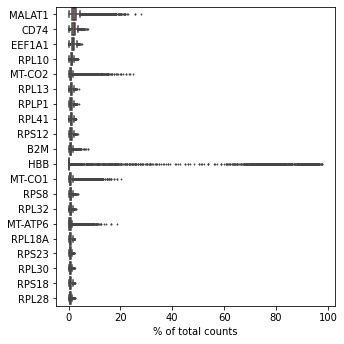

In [5]:
# Step1, data preprocessing
sc.pl.highest_expr_genes(adata, n_top=20)

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)     
adata

filtered out 863 cells that have less than 200 genes expressed
filtered out 13537 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 83679 × 20001 
    obs: 'cell_group', 'cell_subject', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

... storing 'cell_group' as categorical
... storing 'cell_subject' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


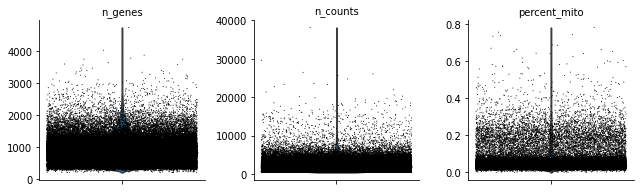

In [7]:
# QC
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

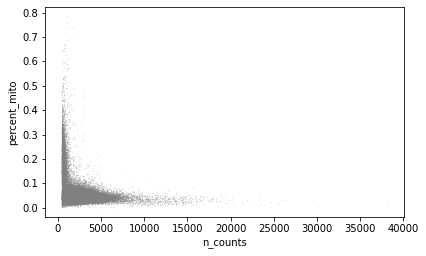

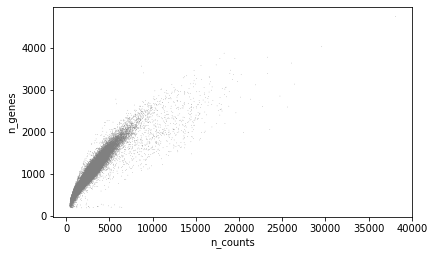

In [8]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [9]:
adata = adata[adata.obs['n_genes'] < 2000, :]
adata = adata[adata.obs['percent_mito'] < 0.2, :]
adata

View of AnnData object with n_obs × n_vars = 80000 × 20001 
    obs: 'cell_group', 'cell_subject', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [10]:
# Normalization
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata 

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


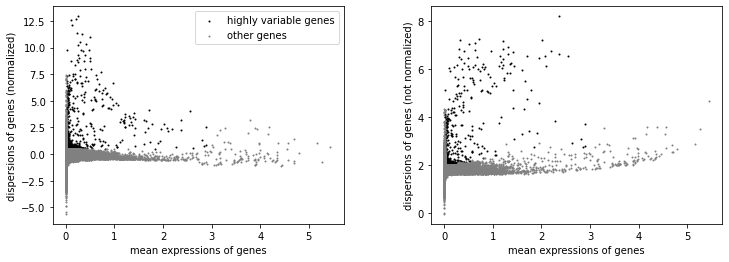

In [11]:
# Identification of variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [12]:
adata.var['highly_variable']

AL627309.1    False
AL669831.5    False
FAM87B        False
LINC00115     False
FAM41C        False
              ...  
AL354822.1    False
AC004556.1    False
AC233755.2     True
AC233755.1     True
AC240274.1    False
Name: highly_variable, Length: 20001, dtype: bool

In [13]:
adata = adata[:, adata.var['highly_variable']]
adata

View of AnnData object with n_obs × n_vars = 80000 × 847 
    obs: 'cell_group', 'cell_subject', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [14]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:50)


    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:09)


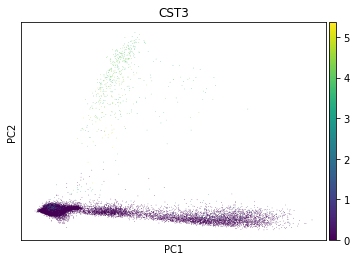

In [15]:
# Step2, PCA
sc.tl.pca(adata, svd_solver='arpack') 
sc.pl.pca(adata, color='CST3')

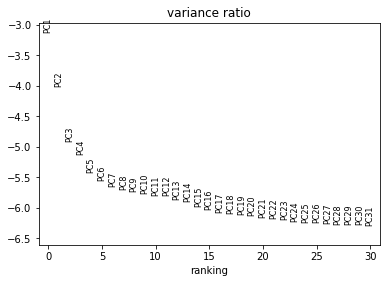

In [16]:
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
adata.write("3.scanpy_pca.h5ad")

In [18]:
# Step3, Clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:17)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:56)


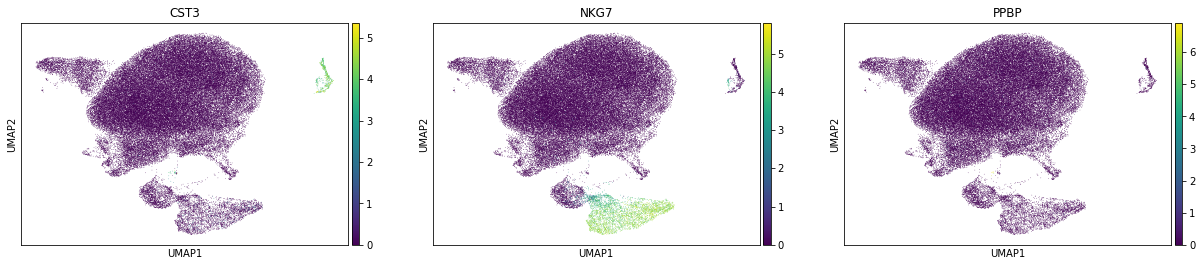

In [19]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

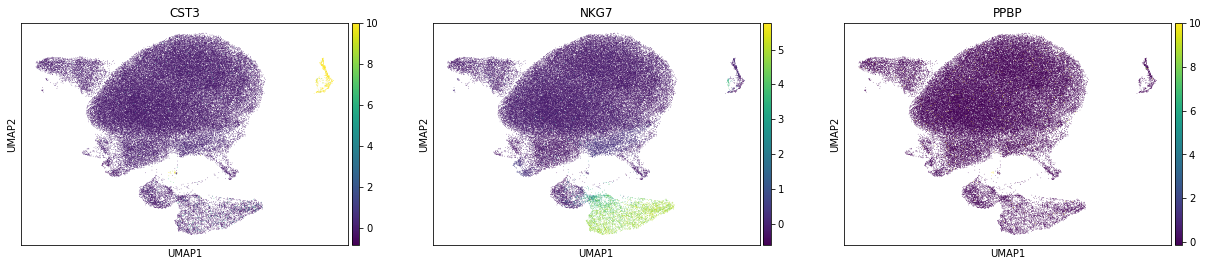

In [20]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

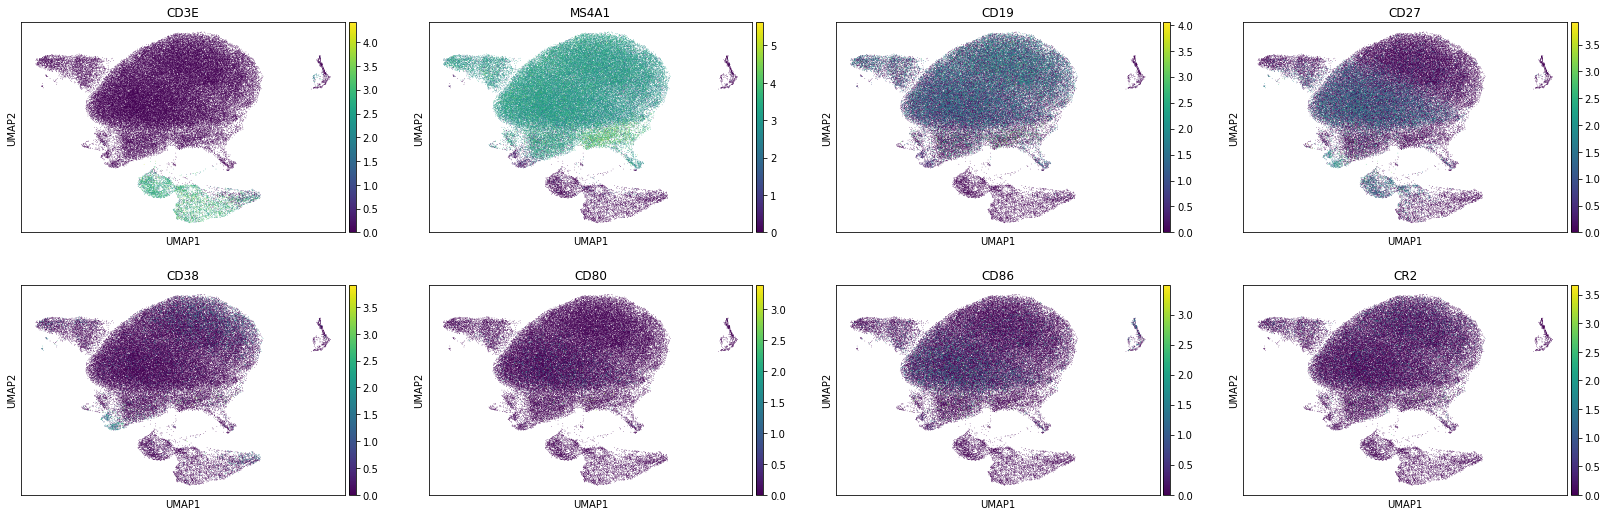

In [21]:
sc.pl.umap(adata, color=['CD3E', 'MS4A1', 'CD19', 'CD27', 'CD38', 'CD80', 'CD86', 'CR2'])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:08)


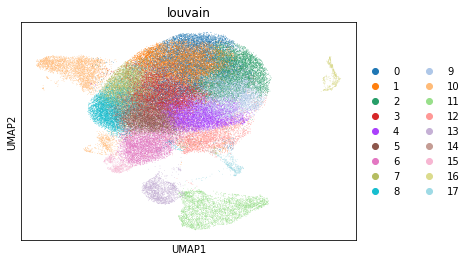

In [22]:
# Clustering
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'])

In [23]:
adata.write("3.scanpy_umap.h5ad")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:39)


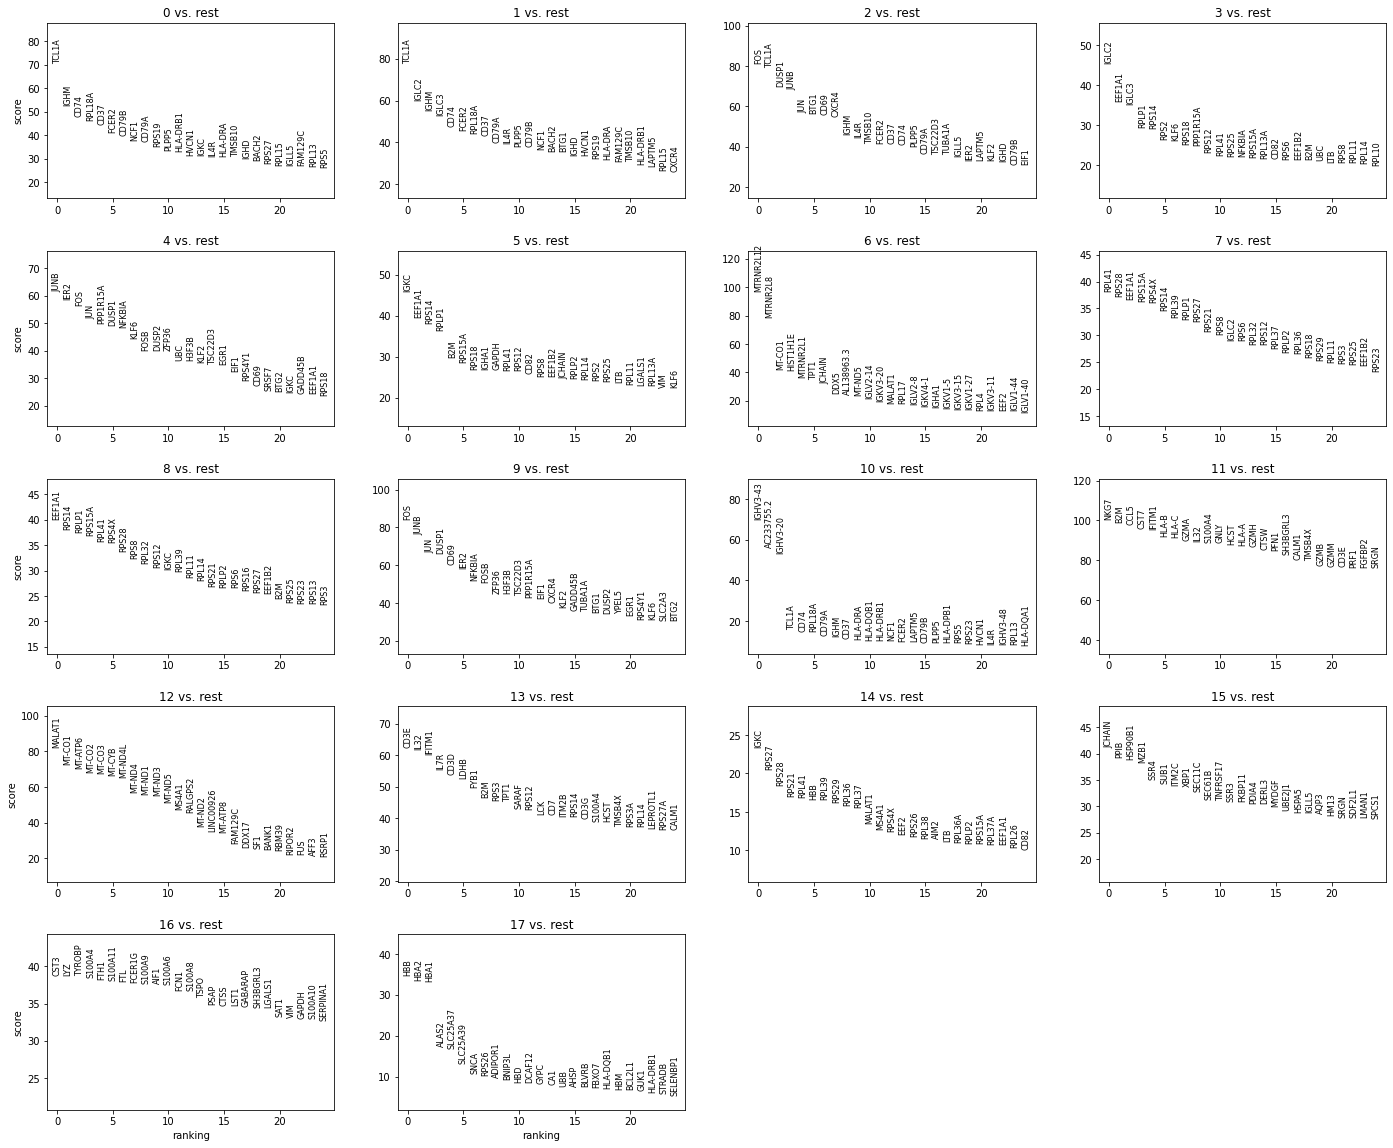

In [24]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

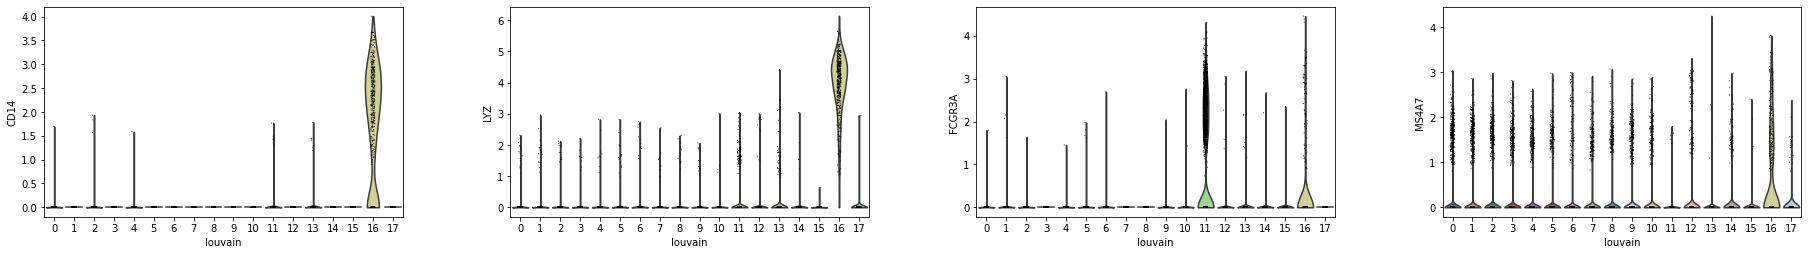

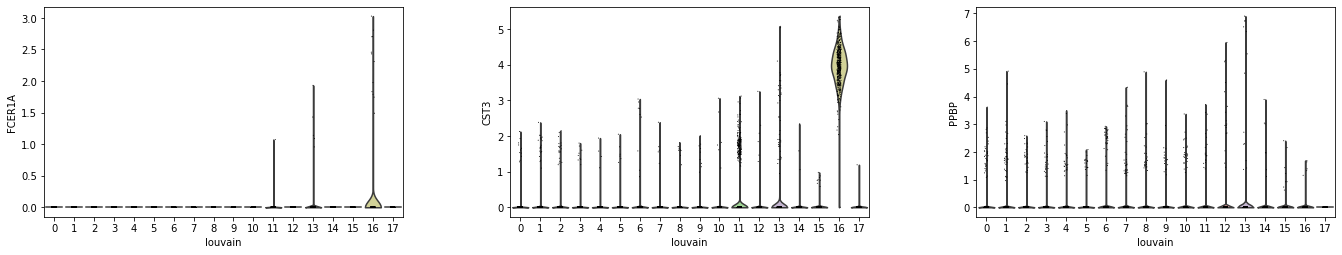

In [25]:
# Monocytes, Dendritic Cells, Megakaryocytes
sc.pl.violin(adata, ['CD14', 'LYZ', 'FCGR3A', 'MS4A7'], groupby='louvain')
sc.pl.violin(adata, ['FCER1A', 'CST3', 'PPBP'], groupby='louvain')

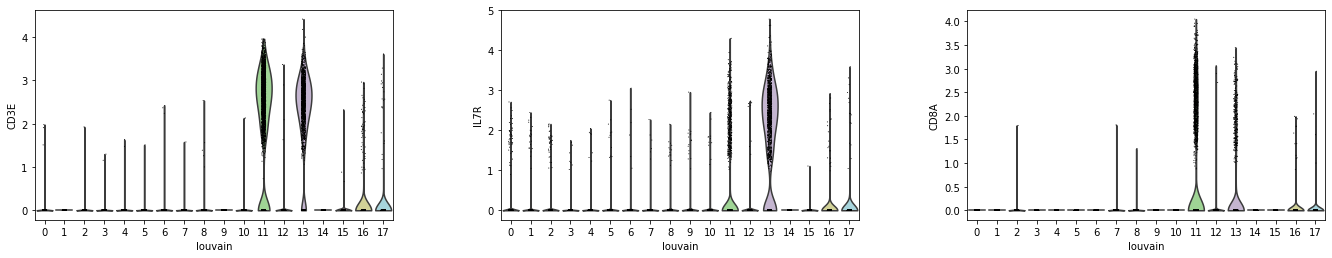

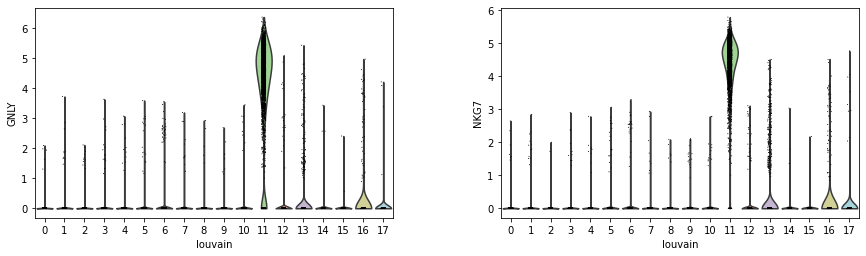

In [26]:
#  T cells
sc.pl.violin(adata, ['CD3E', 'IL7R', 'CD8A'], groupby='louvain')
sc.pl.violin(adata, ['GNLY', 'NKG7'], groupby='louvain')

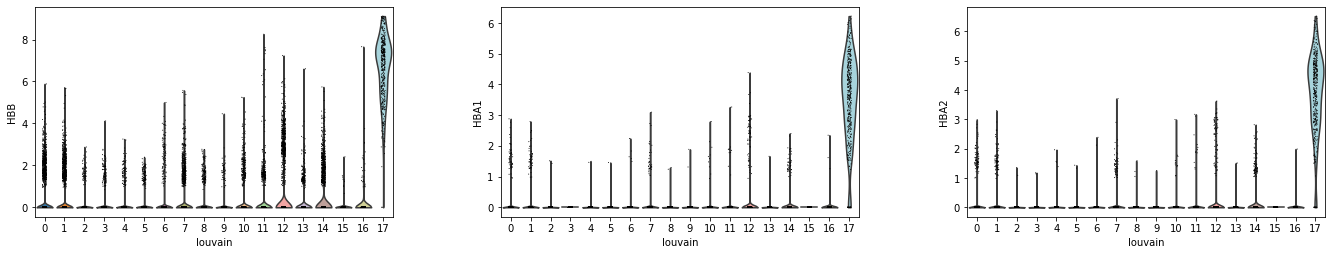

In [27]:
#  Erythoblast
sc.pl.violin(adata, ['HBB', 'HBA1', 'HBA2'], groupby='louvain')

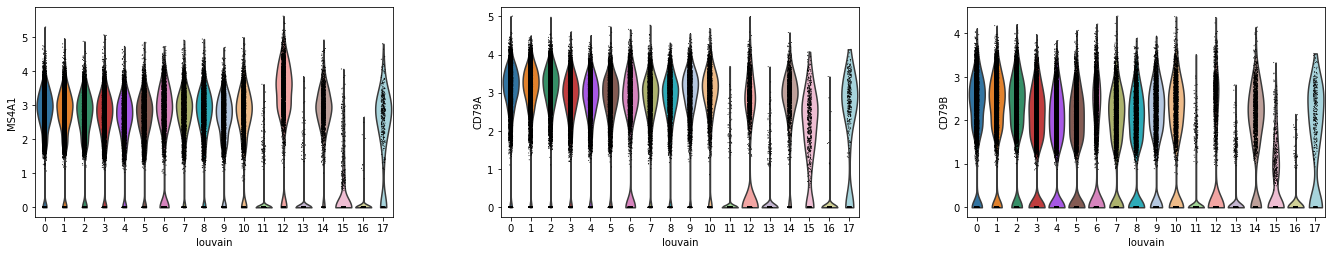

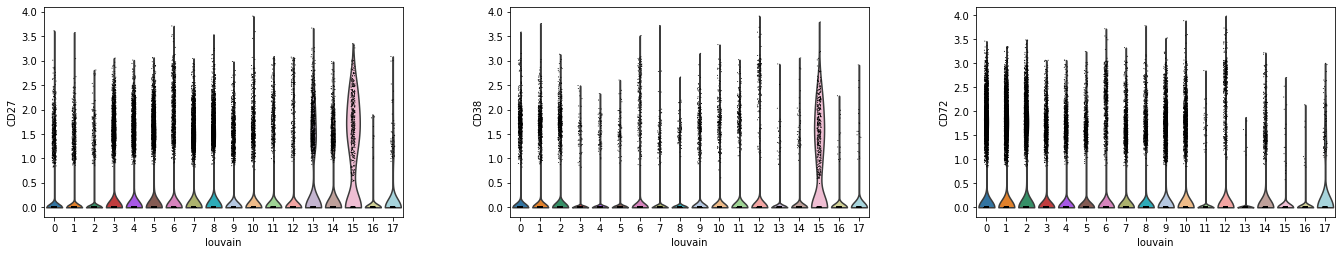

In [28]:
#  B
sc.pl.violin(adata, ['MS4A1', 'CD79A', 'CD79B'], groupby='louvain')
sc.pl.violin(adata, ['CD27', 'CD38', 'CD72'], groupby='louvain')